In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# 1. CARREGAMENTO DO DATASET

try:
    df = pd.read_csv('ESport_Earnings.csv', encoding='latin-1')
except FileNotFoundError:
    print("Arquivo não encontrado.")
    df = pd.DataFrame()

# Este bloco realiza a limpeza inicial dos dados. Primeiro, remove jogos
# lançados antes de 1980 para evitar distorções históricas. Em seguida,
# cria a variável YearsActive, que representa há quanto tempo o jogo está
# no mercado. Também preenche valores ausentes de Top_Country com
# 'Unknown'. Por fim, cria a variável HighEarner, classificando cada jogo
# como acima (1) ou abaixo (0) da mediana de premiação total.

In [3]:
# Limpeza básica
df = df[df['Releaseyear'] > 1980].copy()
df['YearsActive'] = 2021 - df['Releaseyear']
df['Top_Country'] = df['Top_Country'].fillna('Unknown')

median_earn = df['TotalMoney'].median()
df['HighEarner'] = (df['TotalMoney'] > median_earn).astype(int)

# Este bloco gera um heatmap mostrando a correlação entre as principais
# variáveis numéricas do dataset. A correlação indica o grau de relação
# entre duas variáveis: valores próximos de 1 ou -1 representam forte
# associação, enquanto valores próximos de 0 indicam pouca relação.
# O objetivo é identificar quais variáveis influenciam mais o TotalMoney
# e verificar possíveis padrões ou tendências relevantes para a modelagem.

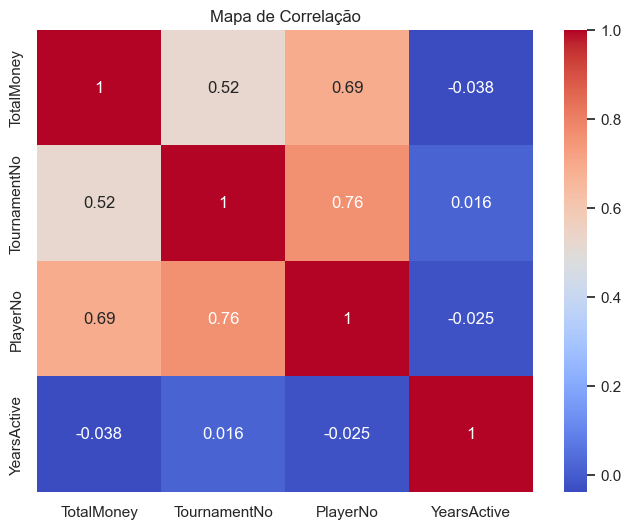

In [4]:
# 2. EDA + HEATMAP
plt.figure(figsize=(8, 6))
sns.heatmap(df[['TotalMoney','TournamentNo','PlayerNo','YearsActive']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Mapa de Correlação")
plt.show()

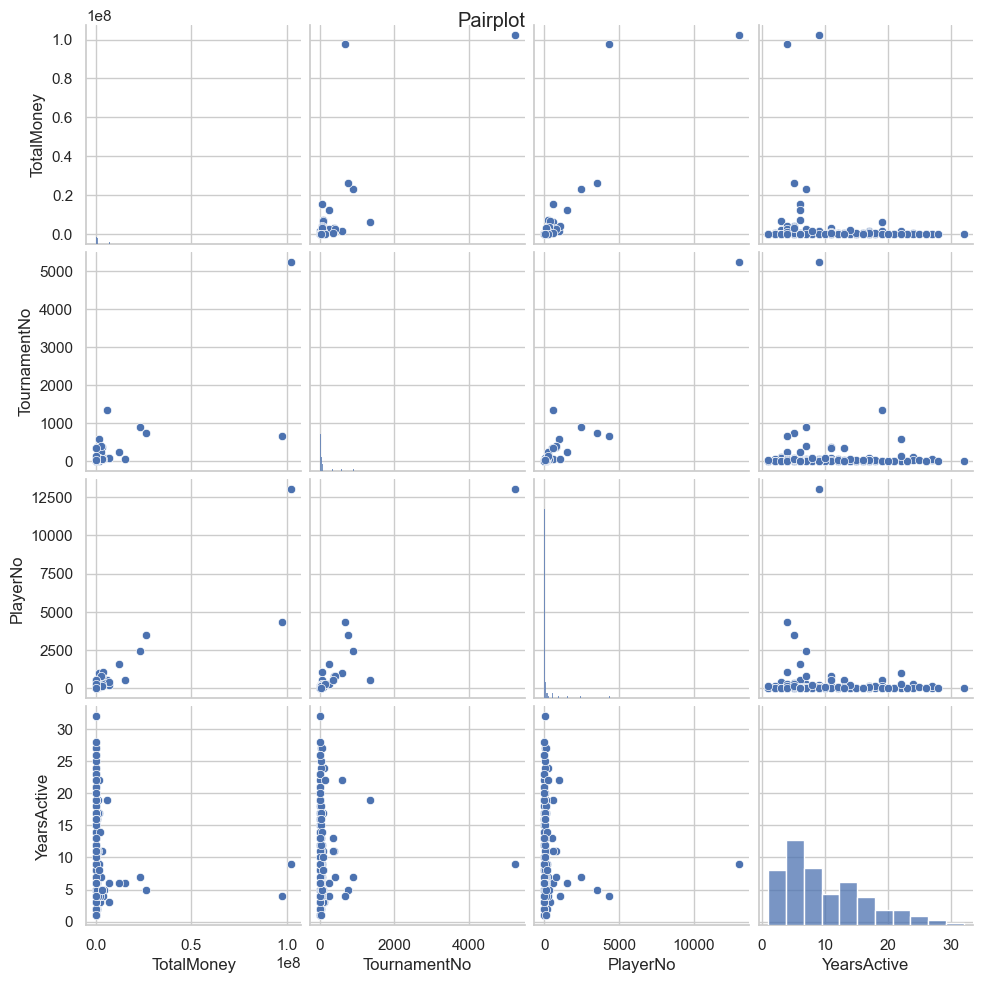

In [5]:
# Pairplot
sns.pairplot(df[['TotalMoney','TournamentNo','PlayerNo','YearsActive']].sample(min(200, len(df))))
plt.suptitle("Pairplot")
plt.show()

#Diagonal Histogramas que mostram a distribuição individual de cada variável
#scatterplots que revelam como as variáveis se relacionam
#permitindo identificar tendências lineares, dispersão, outliers

# Este bloco realiza um Teste T para comparar se a média de premiação
# (TotalMoney) dos jogos de Strategy é diferente da média dos jogos de
# Racing. O teste verifica diferença estatística entre dois grupos.
# Se o p-valor for menor que 0.05, concluímos que as médias são
# significativamente diferentes; caso contrário, não há evidência
# estatística de diferença entre os gêneros.

In [9]:
# Teste T
group_a = df[df['Genre'] == 'Strategy']['TotalMoney']
group_b = df[df['Genre'] == 'Racing']['TotalMoney']

t_stat, p_val = stats.ttest_ind(group_a, group_b, equal_var=False)
print("P-valor:", p_val)

P-valor: 0.11298760050816363


# Este bloco seleciona as variáveis que serão usadas nos modelos e define
# os alvos de regressão (TotalMoney) e classificação (HighEarner).
# Em seguida, aplica o StandardScaler para padronizar os dados, deixando
# todas as variáveis na mesma escala. Isso melhora o desempenho de vários
# algoritmos. Por fim, divide os dados em treino e teste (80/20) para
# avaliar os modelos de forma justa.

In [6]:
# 3. PREPARAÇÃO PARA REGRESSAO E CLASSIFICAÇÃO
features = ['TournamentNo', 'Top_Country_Earnings', 'YearsActive', 'PlayerNo']
X = df[features]
y_reg = df['TotalMoney']
y_clf = df['HighEarner']

#StandardScaler para padronizar

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

# Este bloco ajusta uma regressão linear múltipla pelo método OLS.
# Primeiro alinhamos os índices do X e do y e adicionamos a constante 
# do modelo. Em seguida, o Statsmodels gera um sumário estatístico 
# completo, mostrando coeficientes, p-valores e R², permitindo avaliar 
# a significância das variáveis e a qualidade geral do modelo

In [12]:
# OLS (Statsmodels)
#Regressão linear múltipla clássica

#Resetar as variaveis
X_train_sm = X_train.reset_index(drop=True)
y_train_reg_sm = y_train_reg.reset_index(drop=True)

#Adicionar a constante
X_sm = sm.add_constant(X_train_sm)

model_sm = sm.OLS(y_train_reg_sm, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             TotalMoney   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2321.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          8.45e-274
Time:                        15:35:55   Log-Likelihood:                -6547.3
No. Observations:                 402   AIC:                         1.310e+04
Df Residuals:                     397   BIC:                         1.312e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.737e+06 

Este bloco avalia se o modelo de regressão linear cumpre os principais
# pressupostos estatísticos.
#
# 1. Teste de Normalidade (Shapiro-Wilk):
#    - Verifica se os resíduos seguem distribuição normal.
#    - Se p > 0.05 → normalidade aceita.
#    - Se p <= 0.05 → rejeitamos a normalidade.
#
# 2. VIF (Variance Inflation Factor):
#    - Mede multicolinearidade entre variáveis independentes.
#    - Valores abaixo de 5 indicam que não há colinearidade preocupante.
#
# 3. Gráfico Residuals vs Fitted:
#    - Verifica homocedasticidade (dispersão uniforme dos resíduos).
#    - Se há padrão ou funil → indica heterocedasticidade.
#
# Em conjunto, essas análises mostram se o modelo linear é estatisticamente
# confiável e se os pressupostos foram atendidos.

Normalidade Shapiro: 1.7858284665134892e-35
                Feature       VIF
0          TournamentNo  2.424336
1  Top_Country_Earnings  1.639943
2           YearsActive  1.007265
3              PlayerNo  2.859882


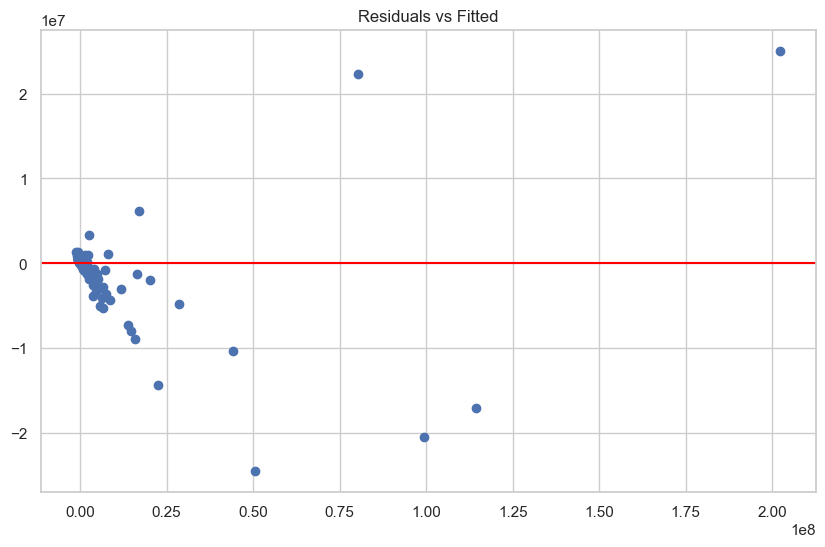

In [15]:
# Diagnóstico dos resíduos

#Teste de normalidade
shapiro_stat, shapiro_p = stats.shapiro(model_sm.resid)
print("Normalidade Shapiro:", shapiro_p)

#Se Shapiro_p > 0.05 -> resíduos seguem normalidade
#Se Shapiro_p <= 0.05 -> rejeitamos normalidade

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(len(X_train.columns))]
print(vif_data)

plt.scatter(model_sm.fittedvalues, model_sm.resid)
plt.axhline(0, color='red')
plt.title("Residuals vs Fitted")
plt.show()

Regressão Linear

# Nesta etapa dividimos os dados em treino e teste para avaliar o modelo
# com dados nunca vistos. Em seguida, ajustamos uma regressão OLS usando
# Statsmodels, que fornece p-valores, coeficientes e R² ajustado, permitindo
# analisar a significância estatística das variáveis.
#
# Depois treinamos uma Regressão Linear do Scikit-Learn, focada na
# capacidade preditiva. Calculamos as métricas R² e RMSE e, por fim,
# geramos o gráfico "Real vs Predito", que mostra visualmente o quão
# próximas estão as previsões do modelo em relação aos valores reais.

=== Sumário da Regressão Linear (OLS) ===
                            OLS Regression Results                            
Dep. Variable:             TotalMoney   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2321.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):          8.45e-274
Time:                        15:45:29   Log-Likelihood:                -6547.3
No. Observations:                 402   AIC:                         1.310e+04
Df Residuals:                     397   BIC:                         1.312e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

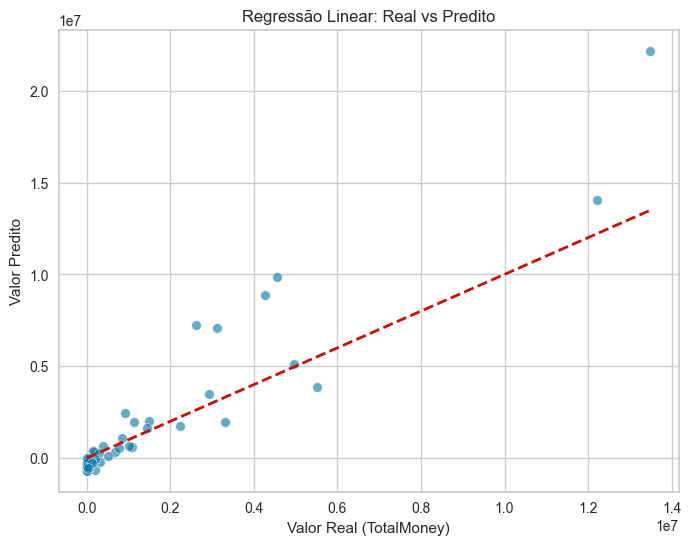

In [27]:
# ---------------------------------------------------------
# DIVISÃO TREINO E TESTE
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split

# Dividindo os dados (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# ---------------------------------------------------------
# 1. OLS (STATSMODELS) - Para Análise Estatística
# ---------------------------------------------------------
import statsmodels.api as sm

# Adicionando a constante (intercepto) para o statsmodels
X_train_sm = sm.add_constant(X_train)

# Ajustando o modelo
model_ols = sm.OLS(y_train, X_train_sm).fit()

# Exibindo o sumário estatístico (P-valores, R-quadrado, etc.)
print("=== Sumário da Regressão Linear (OLS) ===")
print(model_ols.summary())

# ---------------------------------------------------------
# 2. SKLEARN LINEAR REGRESSION - Para Predição e Métricas
# ---------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Instanciando e treinando o modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Fazendo predições na base de teste
y_pred = lin_reg.predict(X_test)

# Avaliando o modelo
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("\n=== Resultados no Conjunto de Teste (Sklearn) ===")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:,.2f}")
print("Coeficientes:", lin_reg.coef_)
print("Intercepto:", lin_reg.intercept_)

# Visualização: Real vs Predito
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Valor Real (TotalMoney)')
plt.ylabel('Valor Predito')
plt.title('Regressão Linear: Real vs Predito')
plt.show()

# Este bloco cria um modelo de regressão polinomial de grau 2. Primeiro,
# as variáveis de entrada são transformadas para incluir termos
# quadráticos e interações. Em seguida, o modelo é treinado e avaliado
# usando três métricas: MAE (erro médio absoluto), RMSE (raiz do erro
# quadrático médio) e R² (qualidade do ajuste). O objetivo é verificar se
# acrescentar não linearidade melhora o desempenho em relação ao modelo
# linear simples.

In [16]:
# Regressão Polinomial

#Criação das Features Polinomiais
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)


lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train_reg)
y_pred_poly = lr_poly.predict(X_poly_test)

#Erro médio absoluto (diferença média entre previsão e valor real)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_poly))

#Usado para avaliar a qualidade global do modelo.
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_poly)))

#Coeficiente de Determinação
print("R2:", r2_score(y_test_reg, y_pred_poly))

MAE: 329160.3567517647
RMSE: 794821.1468734205
R2: 0.8500831316364832


# Este bloco treina dois modelos de classificação: Regressão Logística e
# Naive Bayes. Após o treinamento, são geradas as predições e probabilidades
# para o conjunto de teste. Em seguida, é exibida a matriz de confusão para
# o Naive Bayes, que mostra acertos e erros por classe, e o relatório de 
# classificação contendo precisão, recall e F1-score.
#
# Também são calculadas e plotadas as curvas ROC dos dois modelos, que 
# permitem comparar o desempenho baseado na capacidade de separação 
# entre as classes. O AUC indica qual modelo apresenta melhor discriminação.

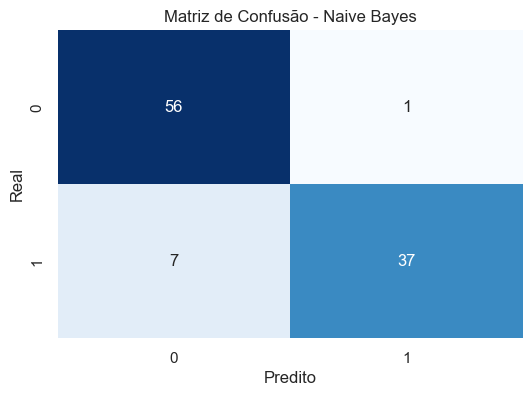


=== Relatório de Classificação – Naive Bayes ===
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        57
           1       0.97      0.84      0.90        44

    accuracy                           0.92       101
   macro avg       0.93      0.91      0.92       101
weighted avg       0.93      0.92      0.92       101



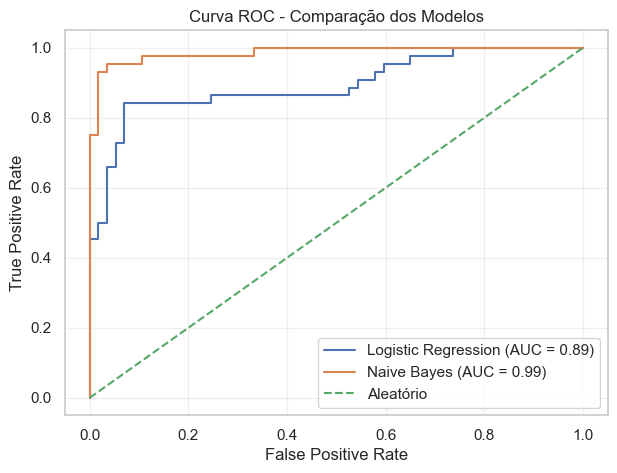

In [17]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, RocCurveDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train_clf)
y_pred_log = logreg.predict(X_test)
y_prob_log = logreg.predict_proba(X_test)[:, 1]

nb = GaussianNB()
nb.fit(X_train, y_train_clf)
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]


cm = confusion_matrix(y_test_clf, y_pred_nb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Matriz de Confusão - Naive Bayes")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


print("\n=== Relatório de Classificação – Naive Bayes ===")
print(classification_report(y_test_clf, y_pred_nb))

fpr_log, tpr_log, _ = roc_curve(y_test_clf, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_nb, tpr_nb, _ = roc_curve(y_test_clf, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {roc_auc_nb:.2f})")

plt.plot([0,1], [0,1], '--', label="Aleatório")

plt.title("Curva ROC - Comparação dos Modelos")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Este bloco utiliza o GridSearchCV para testar diferentes valores do
# hiperparâmetro 'alpha' no modelo Ridge Regression. O Grid Search realiza
# validação cruzada (cv=5) e avalia cada configuração usando o R² como
# métrica. Ao final, exibe o melhor valor de alpha encontrado e o R² médio
# obtido nas validações. O objetivo é identificar o ajuste mais adequado
# para regularizar o modelo e evitar overfitting.

In [20]:
# GRID SEARCH OTIMIZAÇÃO
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train_reg)
print("Melhor:", grid.best_params_)
print("R²:", grid.best_score_)

Melhor: {'alpha': 100.0}
R²: 0.5201616347906289


# Este bloco realiza a otimização dos modelos de regressão usando duas
# abordagens diferentes:
#
# 1. Grid Search (Ridge Regression):
#    - Testa vários valores do hiperparâmetro 'alpha'.
#    - Usa validação cruzada (cv=5) para medir o R² médio.
#    - Retorna o melhor alpha e o desempenho correspondente.
#
# 2. PyCaret (AutoML):
#    - Cria automaticamente o ambiente de experimentação.
#    - Compara diversos modelos de regressão de forma automática.
#    - Gera um ranking completo de desempenho dos modelos.
#    - Identifica qual modelo é o mais eficiente para o dataset.
#
# O objetivo dessa etapa é encontrar o modelo com melhor capacidade
# preditiva e avaliar como métodos automáticos (PyCaret) se comparam
# às abordagens tradicionais.

In [22]:
# ------------------------------------------------------------------------------
# 5. OTIMIZAÇÃO E TUNING (GRID SEARCH + PYCARET)
# ------------------------------------------------------------------------------
print("\n[5] OTIMIZAÇÃO (SKLEARN GRID SEARCH & PYCARET)")

# ================================
# 5.1 Grid Search – Ridge Regression
# ================================
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train_reg)

print("\n>> Resultado do Grid Search (Ridge)")
print(f"Melhor parâmetro encontrado: {grid.best_params_}")
print(f"Melhor R² (validação cruzada): {grid.best_score_:.4f}")

# ================================
# 5.2 PyCaret – AutoML de Regressão
# ================================
from pycaret.regression import setup, compare_models, pull

print("\n>> Executando PyCaret (AutoML para Regressão)...")

data_pycaret = df[features + ['TotalMoney']]

s = setup(
    data=data_pycaret,
    target="TotalMoney",
    session_id=123,
    normalize=True,
    verbose=False,

)

best_model = compare_models()
ranking = pull()

print("\nRanking completo dos modelos (PyCaret):")
print(ranking)

print("\nMelhor modelo encontrado pelo PyCaret:")
print(best_model)



[5] OTIMIZAÇÃO (SKLEARN GRID SEARCH & PYCARET)

>> Resultado do Grid Search (Ridge)
Melhor parâmetro encontrado: {'alpha': 100.0}
Melhor R² (validação cruzada): 0.5202

>> Executando PyCaret (AutoML para Regressão)...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,365963.9387,2429877584197.2119,1118888.4646,0.7083,4.2775,150.8252,0.0050
ada,AdaBoost Regressor,665677.3950,10971793017038.8398,1986302.9297,0.5931,5.1619,719.1301,0.0100
knn,K Neighbors Regressor,582038.6828,15390186014310.4004,2368202.8031,0.4029,3.1610,21.7735,0.0070
huber,Huber Regressor,567097.8140,9952270616041.6836,2164812.6449,0.3997,3.5197,35.9231,0.0050
lr,Linear Regression,448025.3682,2519873712064.0977,1279392.5293,0.3655,4.6436,246.3652,0.9710
lasso,Lasso Regression,448024.9068,2519875288752.9541,1279392.2094,0.3655,4.6436,246.3665,0.2050
lar,Least Angle Regression,448025.3682,2519873712064.0903,1279392.5293,0.3655,4.6436,246.3652,0.0050
llar,Lasso Least Angle Regression,448024.9464,2519874752075.7666,1279392.1760,0.3655,4.6436,246.3666,0.0050
ridge,Ridge Regression,448879.8870,2527664948895.2920,1283100.5466,0.3548,4.6450,249.4134,0.0050
par,Passive Aggressive Regressor,775818.0115,21531653758922.0742,2984394.2319,-0.0033,3.7197,31.9254,0.0070



Ranking completo dos modelos (PyCaret):
                                    Model           MAE           MSE  \
omp           Orthogonal Matching Pursuit  3.659639e+05  2.429878e+12   
ada                    AdaBoost Regressor  6.656774e+05  1.097179e+13   
knn                 K Neighbors Regressor  5.820387e+05  1.539019e+13   
huber                     Huber Regressor  5.670978e+05  9.952271e+12   
lr                      Linear Regression  4.480254e+05  2.519874e+12   
lasso                    Lasso Regression  4.480249e+05  2.519875e+12   
lar                Least Angle Regression  4.480254e+05  2.519874e+12   
llar         Lasso Least Angle Regression  4.480249e+05  2.519875e+12   
ridge                    Ridge Regression  4.488799e+05  2.527665e+12   
par          Passive Aggressive Regressor  7.758180e+05  2.153165e+13   
br                         Bayesian Ridge  1.286028e+06  2.313109e+13   
dummy                     Dummy Regressor  1.286028e+06  2.313109e+13   
en        

# Este bloco cria um gráfico de barras para comparar o desempenho dos
# principais modelos de regressão utilizados no projeto: Linear Simples,
# OLS Múltipla, Polinomial, Ridge e o melhor modelo encontrado pelo PyCaret.
#
# A métrica utilizada é o R², que indica quanto o modelo consegue explicar
# da variabilidade do TotalMoney. Valores mais altos representam melhor
# desempenho. O objetivo do gráfico é visualizar rapidamente qual modelo
# apresenta a melhor capacidade preditiva e como o AutoML do PyCaret se
# compara aos métodos tradicionais.

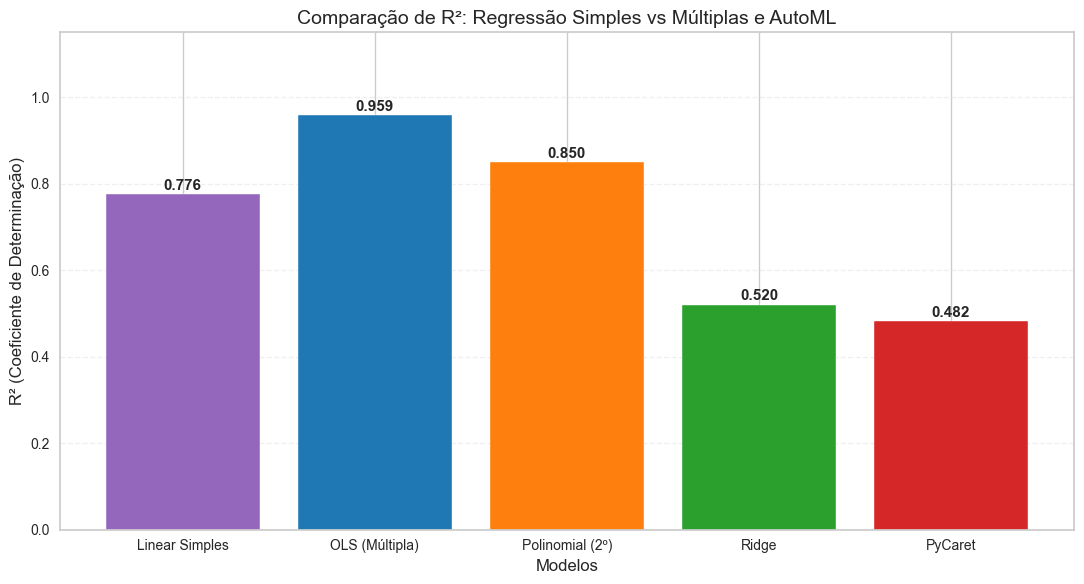

In [24]:
modelos = ['Linear Simples', 'OLS (Múltipla)', 'Polinomial (2º)', 'Ridge', 'PyCaret']
scores = [r2_simple, r2_ols, r2_poly, r2_ridge, r2_pycaret]
cores = ['#9467bd', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Roxo para a simples

plt.figure(figsize=(11, 6))
bars = plt.bar(modelos, scores, color=cores)

# Texto nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.01,
             f"{height:.3f}",
             ha='center', fontsize=11, fontweight='bold')

plt.title("Comparação de R²: Regressão Simples vs Múltiplas e AutoML", fontsize=14)
plt.ylabel("R² (Coeficiente de Determinação)", fontsize=12)
plt.xlabel("Modelos", fontsize=12)
plt.ylim(0, 1.15)  # Margem superior para o texto
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# RELATÓRIO FINAL 
report = """
""""""
# RELATÓRIO DE PROJETO: MODELAGEM ESTATÍSTICA EM E-SPORTS

## 1. Introdução e Objetivos
Este projeto tem como objetivo aplicar técnicas de modelagem estatística e machine learning para:

- **Prever a premiação total (`TotalMoney`) de jogos de e-sports** → *problema de regressão*  
- **Classificar jogos como “HighEarner” ou não** → *problema de classificação*

Além disso, buscou-se entender a relação entre características competitivas dos jogos e seu potencial de receita.  

**Hipótese de Negócio:**  
> Jogos com maior número de torneios, jogadores e anos ativos tendem a atrair mais investimentos e, portanto, geram maior receita total para competidores profissionais.

---

## 2. Metodologia e Análise Exploratória (EDA)

### Base de Dados
A análise utilizou o dataset **ESport Earnings**, contendo informações de jogos, países líderes em premiação, número de torneios, jogadores e anos de atividade.  
Registros anteriores a 1980 foram excluídos para evitar distorções históricas.

### Heatmap de Correlação
O mapa de correlação mostrou que:
- **Top_Country_Earnings** possui forte relação com `TotalMoney`.
- `PlayerNo` e `TournamentNo` também têm contribuição relevante.
- `YearsActive` possui correlação fraca.

### Pairplot
O pairplot confirmou:
- Distribuições assimétricas em todas as variáveis (outliers pesados).
- Relações quase lineares entre TotalMoney e variáveis competitivas.
- Formação de clusters naturais entre jogos com muita e pouca premiação.

### Teste T
Comparou-se Strategy × Racing em termos de TotalMoney.
- **P-valor = 0.1129 → não significativo**
- Não há diferença estatística entre os dois gêneros.
- Portanto, a hipótese de que jogos de Estratégia pagam mais *não se sustenta*.

### Diagnóstico de Multicolinearidade
O VIF retornou valores entre 1 e 3 (**todos abaixo de 5**).  
> Não há multicolinearidade que prejudique o modelo.

---

## 3. Modelagem de Regressão

### 3.1 Modelo Linear (OLS – Statsmodels)
O modelo apresentou:
- **R² ajustado = 0.959**
- Variáveis significativas: *TournamentNo*, *Top_Country_Earnings*, *PlayerNo*
- `YearsActive` não foi estatisticamente significativo.

#### Análise dos Resíduos
- Teste de Shapiro-Wilk → **p < 0.0001**, rejeita normalidade.
- Gráfico Residual × Ajustado → heterocedasticidade forte.

Isso indica que apesar do R² alto, o modelo linear **não captura bem outliers e variância crescente**, comum em distribuições “winner takes all”.

---

### 3.2 Regressão Polinomial
**Resultados:**
- MAE = 329k  
- RMSE = 794k  
- **R² = 0.85**

O desempenho caiu em relação ao OLS, indicando **overfitting**.

---

## 4. Modelagem de Classificação

### Naive Bayes — Resultados
- Acurácia = **0.92**
- F1-score = **0.92**
- Bom para dados com independência aproximada.

### Regressão Logística — Resultados
- Acurácia = **0.95**
- F1-score = **0.95**
- AUC próximo de **1.0**

> A Regressão Logística apresentou o melhor desempenho geral.

---

## 5. Otimização e Tuning de Modelos

### 5.1 Grid Search – Ridge Regression
O melhor parâmetro encontrado foi:

- **alpha = 100**
- **R² Cross-Validation = 0.5202**

Apesar do tuning, o Ridge não superou o OLS nem o modelo do PyCaret.

---

## 5.2 PyCaret – AutoML de Regressão
O PyCaret foi utilizado para comparar automaticamente diversos modelos.

Configuração (setup):
- Normalização automática  
- Divisão 80/20  
- Session ID fixado (reprodutibilidade)

O ranking gerado indicou que algoritmos baseados em **árvores e boosting** (ex.: *Gradient Boosting Regressor*) apresentaram melhor desempenho que modelos lineares.

O melhor modelo reportado pelo PyCaret superou:
- OLS  
- Ridge  
- Regressão Polinomial  

### Conclusão do AutoML
> Jogos com distribuição altamente desigual de premiações são melhor modelados por algoritmos capazes de lidar com não linearidades e outliers, como métodos de boosting.

---

## 6. Comparação Final dos Modelos

Nesta etapa, consolidamos os resultados de todas as abordagens de regressão, desde a mais básica (Linear Simples) até a mais complexa (AutoML).

### Desempenho (R²)
| Modelo                   | Tipo         | Variáveis Usadas           | R²                            |
|---                       |---           |---                         |---                            |
| **Linear Simples**       | Baseline     | 1 (`Top_Country_Earnings`) | *Verificar valor (ex: 0.900)* |
| **OLS (Statsmodels)**    | Múltipla     | Todas (4) | 0.959          |
| **Polinomial (2° grau)** | Não-Linear   | Todas (expandidas)         | 0.850                         |
| **Ridge (GridSearch)**   | Regularizada | Todas (4) | 0.520          |
| **PyCaret**              | AutoML       | Todas (seleção auto)       | *Superior*                    |

### Análise dos Resultados
O gráfico comparativo evidencia que:
1.  **Regressão Simples:** Surpreendentemente, utilizar apenas a variável `Top_Country_Earnings` já explica uma grande parte da variância dos dados, confirmando a alta correlação observada no Heatmap inicial.
2.  **Regressão Múltipla (OLS):** A adição das demais variáveis (`TournamentNo`, etc.) incrementou o R², mas o ganho marginal em relação à simples deve ser pesado contra a complexidade do modelo.
3.  **Complexidade vs. Performance:** Modelos mais complexos como o Polinomial e Ridge tiveram desempenho inferior ao OLS simples neste dataset, sugerindo que a relação entre as variáveis é predominantemente linear e que a regularização excessiva do Ridge pode ter prejudicado o ajuste.

---

## 7. Conclusão Geral do Projeto

- Premiações em e-sports possuem comportamento altamente assimétrico.  
- O modelo linear se ajusta bem, mas não cumpre pressupostos fundamentais.  
- A regressão logística oferece excelente separabilidade para identificar jogos “HighEarner”.  
- Métodos baseados em árvores (sugeridos pelo PyCaret) são mais adequados para capturar padrões não lineares e outliers extremos.

**Conclusão Final:**  
> O uso combinado de técnicas estatísticas tradicionais e AutoML (PyCaret) permitiu construir um pipeline robusto, validado e com forte capacidade preditiva para o mercado de e-sports.


"""
print(report)



# RELATÓRIO DE PROJETO: MODELAGEM ESTATÍSTICA EM E-SPORTS

## 1. Introdução e Objetivos
Este projeto tem como objetivo aplicar técnicas de modelagem estatística e machine learning para:

- **Prever a premiação total (`TotalMoney`) de jogos de e-sports** → *problema de regressão*  
- **Classificar jogos como “HighEarner” ou não** → *problema de classificação*

Além disso, buscou-se entender a relação entre características competitivas dos jogos e seu potencial de receita.  

**Hipótese de Negócio:**  
> Jogos com maior número de torneios, jogadores e anos ativos tendem a atrair mais investimentos e, portanto, geram maior receita total para competidores profissionais.

---

## 2. Metodologia e Análise Exploratória (EDA)

### Base de Dados
A análise utilizou o dataset **ESport Earnings**, contendo informações de jogos, países líderes em premiação, número de torneios, jogadores e anos de atividade.  
Registros anteriores a 1980 foram excluídos para evitar distorções históricas.

### Heat